In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

In [2]:
# Set up Indonesian stopwords and stemmer
stop_factory = StopWordRemoverFactory()
stopwords_sastrawi = set(stop_factory.get_stop_words())
stemmer = StemmerFactory().create_stemmer()
custom_stopwords = {
    # Pronouns & common personal references
    'aku', 'kamu', 'dia', 'kami', 'kita', 'mereka', 'saya', 'anda', 'gw', 'gue', 'lu', 'loe', 'lo', 'gua', 'kak',
    
    # Formal stopwords
    'yang', 'dan', 'di', 'ke', 'dari', 'pada', 'dengan', 'untuk', 'dalam', 'adalah', 'itu', 'ini',
    'juga', 'sebagai', 'oleh', 'karena', 'agar', 'atau', 'tetapi', 'namun', 'sehingga', 'supaya',
    'bagi', 'tanpa', 'bahwa', 'kalau', 'jika', 'saat', 'sebelum', 'sesudah', 'setelah', 'sementara',
    'sambil', 'sedangkan', 'seperti', 'hingga', 'meskipun',

    # Common verbs & auxiliaries
    'adalah', 'ialah', 'merupakan', 'bukan', 'sudah', 'belum', 'akan', 'lagi', 'pernah',
    'harus', 'mau', 'dapat', 'bisa',

    # Informal abbreviations/slang
    'gak', 'ga', 'nggak', 'ngga', 'tdk', 'ngerti', 'sih', 'aja', 'kok', 'dong', 'nih', 'deh',
    'ya', 'yah', 'yee', 'loh', 'lah', 'cie', 'eh', 'btw', 'kalo', 'kalau', 'tp', 'yg', 'dr', 'pd', 'trs', 'klo'

    # Internet filler
    'wkwk', 'wkwkwk', 'haha', 'hehe', 'huhu', 'ckck', 'lol', 'lmao', 'anjay', 'banget', 'mantul',

    # Temporal
    'kemarin', 'besok', 'nanti', 'sekarang', 'tadi', 'barusan',

    # Common question words
    'apa', 'kenapa', 'mengapa', 'dimana', 'kapan', 'siapa', 'bagaimana'
}

extended_stopwords = stopwords_sastrawi.union(custom_stopwords)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in extended_stopwords])
    text = stemmer.stem(text)  # stemming in Bahasa Indonesia
    return text

# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r"http\S+", "", text)
#     text = re.sub(r"@\w+", "", text)
#     text = re.sub(r"#\w+", "", text)
#     text = re.sub(r"[^\w\s]", "", text)
#     text = re.sub(r"\d+", "", text)
#     words = text.split()
#     words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
#     return " ".join(words)

In [4]:
df = pd.read_csv('translated_dataset_formal.csv')

text_column = 'translated_text_formal'
label_column = 'label'

df = df[[text_column, label_column]].dropna()
df[text_column] = df[text_column].astype(str).apply(preprocess_text)

if df[label_column].dtype != int:
    le = LabelEncoder()
    df[label_column] = le.fit_transform(df[label_column])

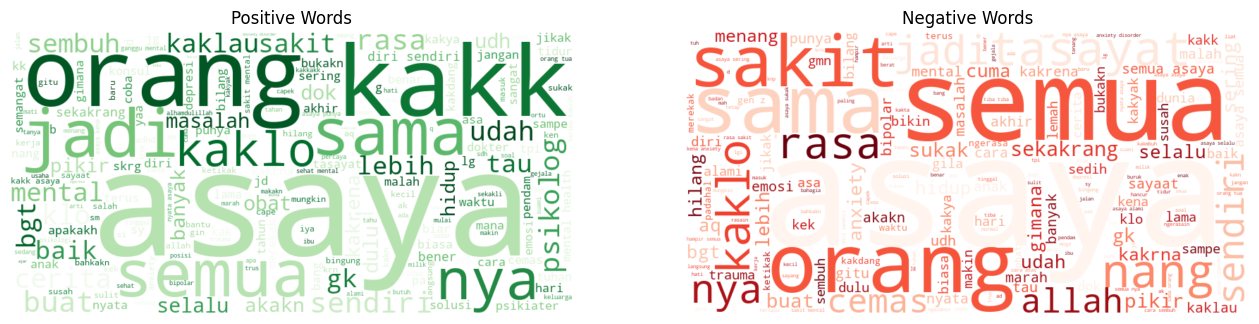

In [5]:
positive_texts = df[df[label_column] == 1][text_column]
negative_texts = df[df[label_column] == 0][text_column]

positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(' '.join(positive_texts))
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(' '.join(negative_texts))

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

In [6]:
vocab_size = 10000
max_len = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df[text_column])
sequences = tokenizer.texts_to_sequences(df[text_column])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

word_index = tokenizer.word_index

In [7]:
embedding_index = {}
embedding_dim = 300  # FastText Indo = 300 dimensions

with open('cc.id.300.vec', encoding='utf-8') as f:
    next(f)  # Skip the header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

# embedding_index = {}
# with open('glove.6B.100d.txt', encoding='utf8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vector = np.asarray(values[1:], dtype='float32')
#         embedding_index[word] = vector

# embedding_matrix = np.zeros((vocab_size, embedding_dim))
# for word, i in word_index.items():
#     if i < vocab_size:
#         embedding_vector = embedding_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df[label_column], test_size=0.2, random_state=42)

In [9]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_len))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\Mufid Musyaffa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,321 (12.33 MB)

 Trainable params: 3,232,321 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 120ms/step - accuracy: 0.7400 - loss: 0.8871 - val_accuracy: 0.8025 - val_loss: 0.4618
Epoch 2/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.8419 - loss: 0.3934 - val_accuracy: 0.8075 - val_loss: 0.4450
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step - accuracy: 0.8844 - loss: 0.2980 - val_accuracy: 0.8011 - val_loss: 0.4966
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.9194 - loss: 0.2205 - val_accuracy: 0.7829 - val_loss: 0.5748
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.9315 - loss: 0.1937 - val_accuracy: 0.7968 - val_loss: 0.6600


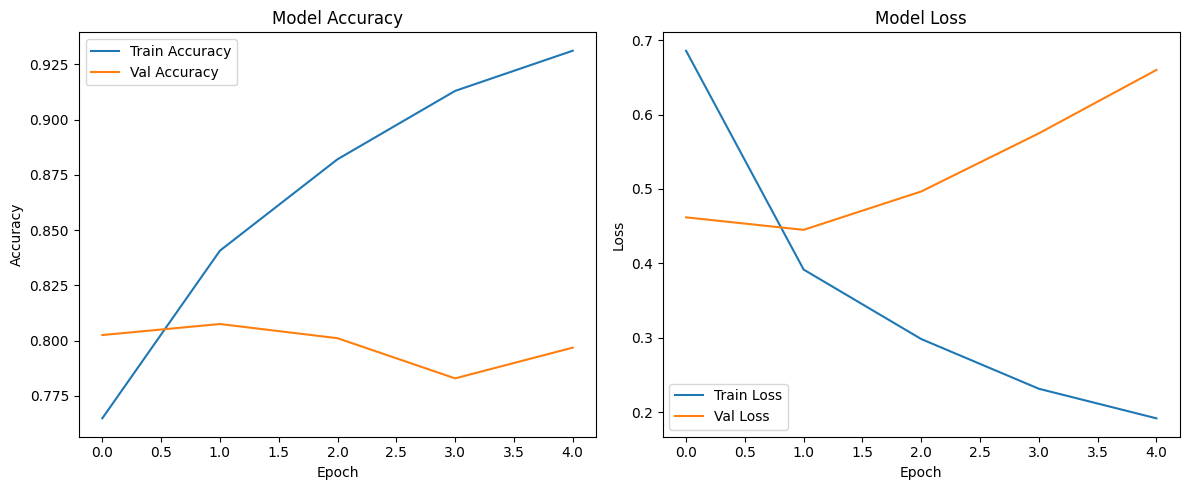

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


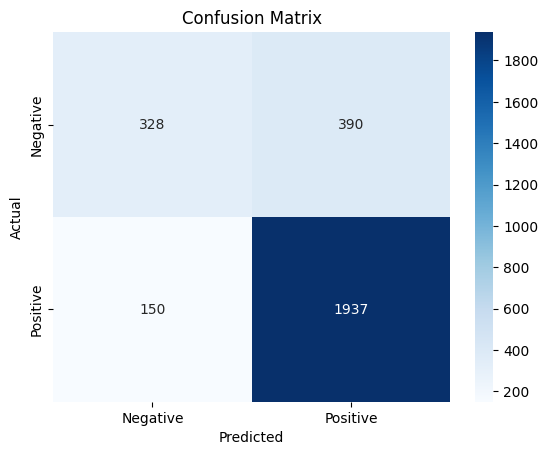


Classification Report:

              precision    recall  f1-score   support

    Negative       0.69      0.46      0.55       718
    Positive       0.83      0.93      0.88      2087

    accuracy                           0.81      2805
   macro avg       0.76      0.69      0.71      2805
weighted avg       0.79      0.81      0.79      2805



In [12]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [17]:
model.save('sentiment_model.h5')